**I. EDA**

In [2]:
import os
import cv2
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer,LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import roc_curve, auc

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from keras.backend import clear_session


from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the labels CSV files
train_labels = pd.read_csv('/kaggle/input/d/shuvoalok/raf-db-dataset/test_labels.csv')
test_labels = pd.read_csv('/kaggle/input/d/shuvoalok/raf-db-dataset/test_labels.csv')

# Display the first few rows of the train labels to check the structure
print(train_labels.head())

classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']


label_map = {label: (idx+1) for idx, label in enumerate(classes)}

print(label_map)

                   image  label
0  test_0001_aligned.jpg      5
1  test_0002_aligned.jpg      1
2  test_0003_aligned.jpg      4
3  test_0004_aligned.jpg      1
4  test_0005_aligned.jpg      5
{'surprise': 1, 'fear': 2, 'disgust': 3, 'happy': 4, 'sad': 5, 'angry': 6, 'neutral': 7}


In [4]:
# Function to load images and labels from the directory
def load_data(dataset_dir, label_map):
    images = []
    labels = []
    
    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))  # +1 because folder names start from '1'
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(idx)
    
    return np.array(images), np.array(labels)

# Load train and test datasets
train_images, train_labels = load_data('/kaggle/input/d/shuvoalok/raf-db-dataset/DATASET/train', label_map)
test_images, test_labels = load_data('/kaggle/input/d/shuvoalok/raf-db-dataset/DATASET/test', label_map)
print(train_images.shape)
print(test_images.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

(12271, 100, 100, 3)
(3068, 100, 100, 3)


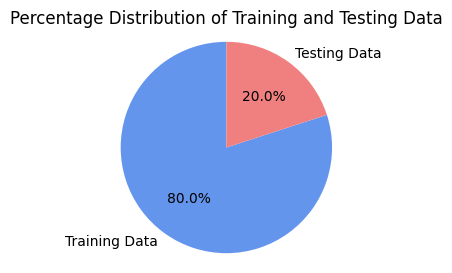

In [5]:
# Calculate the total number of images
total_images = len(train_images) + len(test_images)

# Calculate percentages
train_percentage = (len(train_images) / total_images) * 100
test_percentage = (len(test_images) / total_images) * 100

# Data for pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  
plt.show()


train_label_counts  Counter({4: 4772, 7: 2524, 5: 1982, 1: 1290, 3: 717, 6: 705, 2: 281})
test_counts [329, 74, 160, 1185, 478, 162, 680]


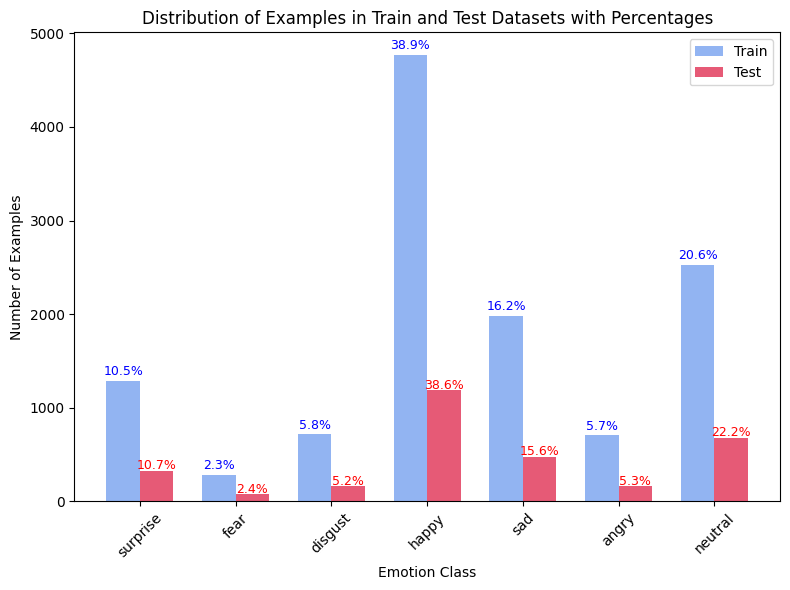

In [6]:
# Count the distribution of classes in train and test datasets
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)
print('train_label_counts ',train_label_counts)
# Convert to sorted lists for plotting
train_classes = sorted(train_label_counts.keys())
train_counts = [train_label_counts[cls] for cls in train_classes]

test_classes = sorted(test_label_counts.keys())
test_counts = [test_label_counts[cls] for cls in test_classes]
print('test_counts',test_counts)
# Calculate the total number of examples in train and test datasets
total_train = sum(train_counts)
total_test = sum(test_counts)

# Calculate percentages for train and test datasets
train_percentages = [(count / total_train) * 100 for count in train_counts]
test_percentages = [(count / total_test) * 100 for count in test_counts]

# Plot the distribution with percentages
plt.figure(figsize=(8, 6))
x = range(len(classes))
bar_width = 0.35

plt.bar(x, train_counts, width=bar_width, label="Train", alpha=0.7, color="cornflowerblue")
plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label="Test", alpha=0.7, color="crimson")

# Annotate percentages on bars
for i, (train_count, test_count) in enumerate(zip(train_counts, test_counts)):
    plt.text(i, train_count + 0.005 * total_train, f"{train_percentages[i]:.1f}%", ha='center', color="blue", fontsize=9)
    plt.text(i + bar_width, test_count + 0.005 * total_test, f"{test_percentages[i]:.1f}%", ha='center', color="red", fontsize=9)

# Add labels and title
plt.xticks([p + bar_width / 2 for p in x], classes, rotation=45)
plt.xlabel("Emotion Class")
plt.ylabel("Number of Examples")
plt.title("Distribution of Examples in Train and Test Datasets with Percentages")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# Combine the train and test datasets into the same variables
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)

# Display the shapes to confirm
print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)


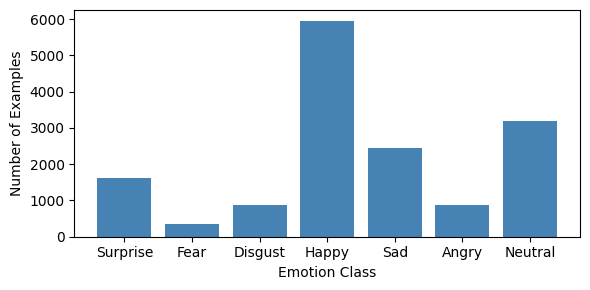

In [8]:
# Count the distribution of classes in the resampled train dataset
train_label_counts_resampled = Counter(Y_train)
    
# Convert to sorted lists for plotting
train_classes_resampled = sorted(train_label_counts_resampled.keys())
train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]
# Plot the distribution
plt.figure(figsize=(6, 3))
x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']
    
# Bar plot for the resampled distribution
plt.bar(x_labels, train_counts_resampled, color="steelblue")
    
# Add labels and title
plt.xlabel("Emotion Class")
plt.ylabel("Number of Examples")
plt.title('')
plt.tight_layout()
    
# Show the plot
plt.show()

In [9]:
# Shuffle X_train and Y_train
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

# Display the shapes to confirm the data is shuffled
print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)


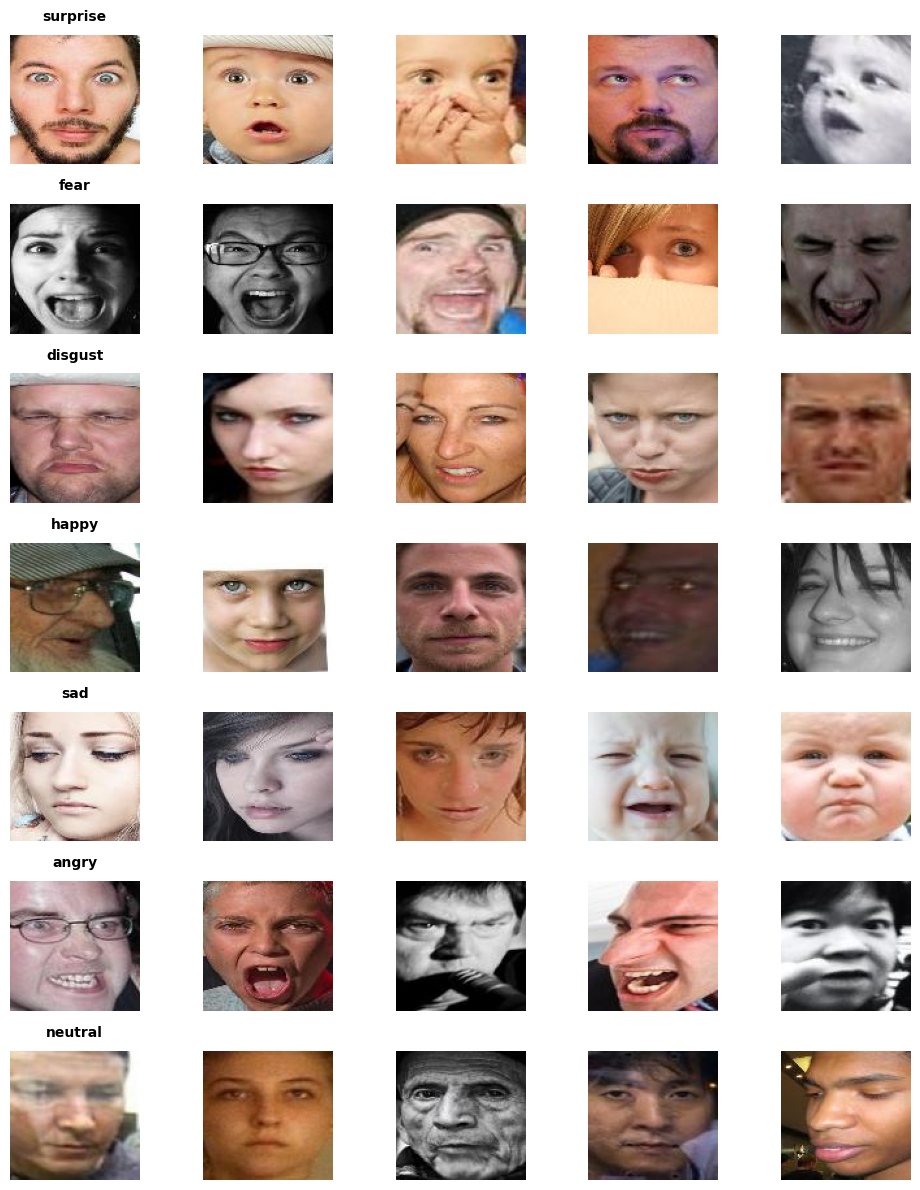

In [10]:
def show_examples(train_images, train_labels, labels, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 12))
    
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(train_labels) if label == i+1]
        selected_indices = np.random.choice(class_indices, num_examples, replace=False)
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        # Display the random images for the current class
        for j, idx in enumerate(selected_indices):
            img = train_images[idx]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images for each class
show_examples(X_train, Y_train, classes)

In [11]:
# most frequent image sizes :
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Count occurrences for each size
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Sort shapes by count
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# show most frequent size
print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (100, 100, 3): 15339


**II. Data Procesing**

**1. Oversampling**

In [12]:
# Function to plot the class distribution
def plot_class_distribution(y, title):
    # Count the distribution of classes in the resampled train dataset
    train_label_counts_resampled = Counter(y)
    
    # Convert to sorted lists for plotting
    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]
    
    # Plot the distribution
    plt.figure(figsize=(6, 3))
    x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']
    
    # Bar plot for the resampled distribution
    plt.bar(x_labels, train_counts_resampled, color="steelblue")
    
    # Add labels and title
    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

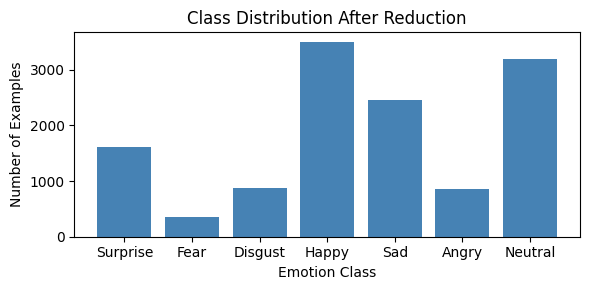

In [13]:
# Function to reduce the size of a specific class in the dataset
def reduce_class(X, y, target_class, target_size):
    # Separate the target class
    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]
    
    # Randomly sample the target class to the desired size
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)
    
    # Combine the reduced class with the other classes
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]
    
    return X_reduced, y_reduced

target_class = 4  # The 'happy' class
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)
# Plot the new distribution after reduction
plot_class_distribution(y_train_reduced, "Class Distribution After Reduction")

Classe 1: 1619 augmented samples with 1881 samples.
Classe 2: 355 augmented samples with 3145 samples.
Classe 3: 877 augmented samples with 2623 samples.
Classe 5: 2460 augmented samples with 1040 samples.
Classe 6: 867 augmented samples with 2633 samples.
Classe 7: 3204 augmented samples with 296 samples.


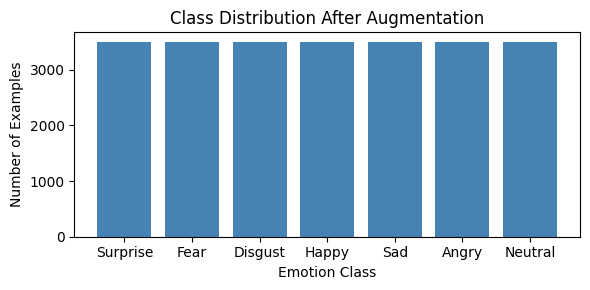

In [14]:
def augment_classes(images, labels, target_counts):
    #Initialization of augmented image generation
    datagen = ImageDataGenerator(
        rotation_range=10,             
        width_shift_range=0.1,         
        height_shift_range=0.1,  
        zoom_range=0.1,
        vertical_flip=False,               
        horizontal_flip=True, 
        channel_shift_range=50.0,
        fill_mode='nearest'
    )

    augmented_images = images.copy()  
    augmented_labels = labels.copy()  

    # For each class, we increase the number of samples
    for target_class, target_count in target_counts.items():
        # Filtering images and labels for the target class
        class_images = images[labels == target_class]
        class_labels = labels[labels == target_class]
        # Calculating the number of samples to generate
        augment_count = target_count - len(class_images)

        if augment_count > 0:
            print(f'Classe {target_class}: {len(class_images)} augmented samples with {augment_count} samples.')

            #Creating an iterator for the target class
            class_images_augmented = []
            class_labels_augmented = []

            # Apply augmentation iteratively
            for batch in datagen.flow(class_images, batch_size=1, seed=42):
                aug_image = batch[0].astype(np.uint8)
                class_images_augmented.append(aug_image)
                class_labels_augmented.append(target_class)
                
                # Stop when the desired number of augmented images is reached
                if len(class_images_augmented) >= augment_count:
                    break
            
            # Add the augmented images to the original dataset
            augmented_images = np.vstack((augmented_images, np.array(class_images_augmented)))
            augmented_labels = np.hstack((augmented_labels, np.array(class_labels_augmented)))

    return augmented_images, augmented_labels

# Example usage
target_counts = {1: 3500, 2: 3500, 3: 3500, 5: 3500, 6: 3500, 7: 3500}  # Target counts for each class
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced, target_counts)

# Visualize the class distribution after augmentation
plot_class_distribution(y_train_augmented, "Class Distribution After Augmentation")

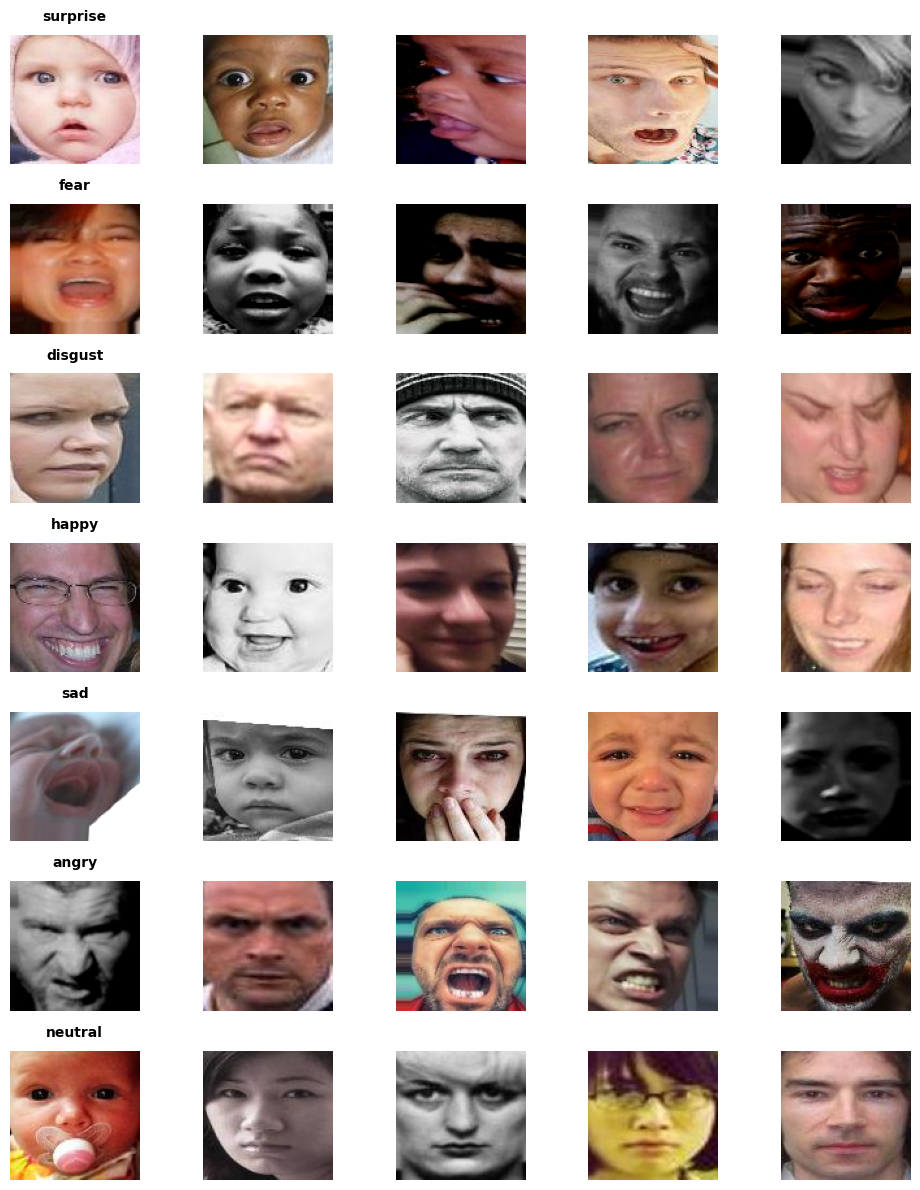

In [15]:
# Show sample images for each class
show_examples(X_train_augmented, y_train_augmented, classes)

**2. Split Dataset**

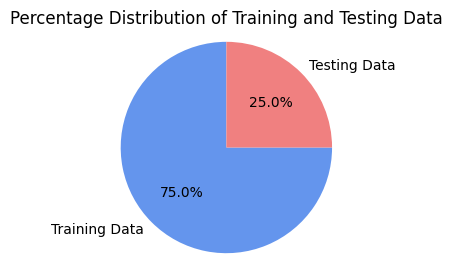

In [16]:
# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_train_augmented, 
                                                    y_train_augmented, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    random_state=42)

# Calculate the total number of images
total_images = len(X_train) + len(X_test)

# Calculate percentages
train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100

# Data for pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  
plt.show()


**3. Normalize the images**

In [17]:
def normalize_images(images):
    # Normalize pixel values to [0, 1]
    return images / 255.0

train_images_normalized = normalize_images(X_train)
test_images_normalized = normalize_images(X_test)

In [18]:
#Reshape the Image
def reshape_images(images, model_type='CNN'):
    if model_type == 'SVM':
        # SVM needs the images to be flattened (1D)
        return images.reshape((images.shape[0], -1))
    elif model_type in ['CNN']:
        # CNN and DenseNet require images to have shape (height, width, channels)
        return images.reshape((images.shape[0], 100, 100, 3))

train_images_SVMreshaped = reshape_images(train_images_normalized, model_type='SVM')
test_images_SVMreshaped = reshape_images(test_images_normalized, model_type='SVM')

train_images_CNNreshaped = reshape_images(train_images_normalized, model_type='CNN')
test_images_CNNreshaped = reshape_images(test_images_normalized, model_type='CNN')

In [19]:
# Convert labels to categorical for CNN
Y_train_cat = to_categorical(Y_train - 1, num_classes=len(classes))
Y_test_cat = to_categorical(Y_test - 1, num_classes=len(classes))

4. Data Augmentation For CNN and DenseNet

In [20]:
datagen = ImageDataGenerator(
    rotation_range=20,             
    width_shift_range=0.1,         
    height_shift_range=0.1,  
    vertical_flip=False,               
    horizontal_flip=True, 
    fill_mode='nearest'
)

# Create the generator for training
train_generator = datagen.flow(train_images_CNNreshaped, Y_train_cat, batch_size=64)

5. Standization for Random Forest model

In [22]:
# === 1. HOG feature extractor ===
def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (64, 64))
        feature = hog(resized,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      feature_vector=True)
        hog_features.append(feature)
    return np.array(hog_features)

In [24]:
# 2. Trích HOG đặc trưng 
print("🔍 Extracting HOG features...")
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

🔍 Extracting HOG features...


III. Model Training

1. Random Forest

In [25]:
print("Training Random Forest")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_hog, Y_train)

Training Random Forest


RandomForestClassifier(class_weight='balanced', random_state=42)

In [26]:
# === 4. Dự đoán và đánh giá ===
y_pred = rf_model.predict(X_test_hog)

print(f"\n✅ Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print("\n📄 Classification Report:")
print(classification_report(Y_test, y_pred))


✅ Accuracy: 0.4994

📄 Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.48      0.49       870
           2       0.49      0.55      0.52       840
           3       0.39      0.34      0.37       910
           4       0.63      0.77      0.69       887
           5       0.45      0.24      0.32       865
           6       0.47      0.48      0.48       859
           7       0.50      0.62      0.55       894

    accuracy                           0.50      6125
   macro avg       0.49      0.50      0.49      6125
weighted avg       0.49      0.50      0.49      6125



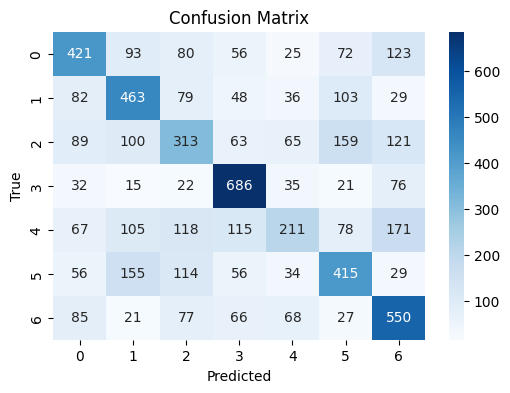

In [27]:
# === 5. Confusion matrix ===
conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

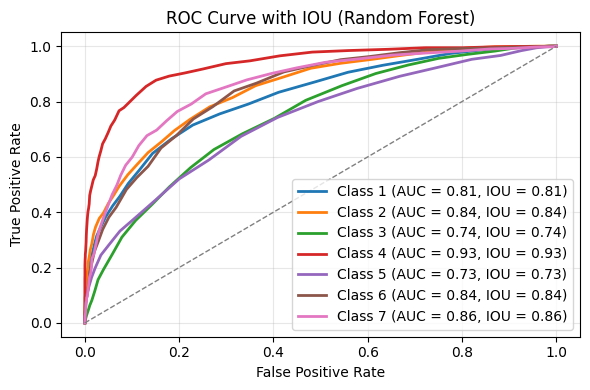

In [28]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Binarize nhãn test ---
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(Y_test)

# --- 2. Lấy xác suất dự đoán ---
y_pred_prob = rf_model.predict_proba(X_test_hog)  # shape = (num_samples, num_classes)

# --- 3. Khởi tạo dict chứa các giá trị ---
fpr = {}
tpr = {}
roc_auc = {}
iou_scores = {}

# --- 4. Tính ROC, AUC, IOU cho từng lớp ---
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    iou_scores[i] = np.trapz(tpr[i], fpr[i])  # IOU ~ area under TPR vs FPR

# --- 5. Vẽ biểu đồ ROC ---
plt.figure(figsize=(6, 4))
for i in range(len(lb.classes_)):
    class_name = lb.classes_[i]
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_name} (AUC = {roc_auc[i]:.2f}, IOU = {iou_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with IOU (Random Forest)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Clear memory
clear_session()
gc.collect()

0

2****.CNN Model**

In [30]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(test_images_CNNreshaped[0].shape)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750354667.591377      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750354667.592042      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 512)           │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,881,991 (18.62 MB)

 Trainable params: 4,881,991 (18.62 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the CNN model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)  
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

CNN_History = cnn_model.fit(
    train_generator,
    epochs=60, 
    batch_size = 32,
    validation_data=(test_images_CNNreshaped, Y_test_cat), 
    callbacks=[reduce_lr, early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1750354678.308993      87 service.cc:148] XLA service 0x7f6758009270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750354678.314396      87 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750354678.314423      87 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750354678.836758      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/288 ━━━━━━━━━━━━━━━━━━━━ 42:24 9s/step - accuracy: 0.1250 - loss: 1.9578

I0000 00:00:1750354684.319301      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.1997 - loss: 1.8929
Epoch 1: val_accuracy improved from -inf to 0.29518, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.1998 - loss: 1.8928 - val_accuracy: 0.2952 - val_loss: 1.7464 - learning_rate: 0.0010
Epoch 2/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3304 - loss: 1.7214
Epoch 2: val_accuracy improved from 0.29518 to 0.43429, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 45s 155ms/step - accuracy: 0.3305 - loss: 1.7212 - val_accuracy: 0.4343 - val_loss: 1.4892 - learning_rate: 0.0010
Epoch 3/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4372 - loss: 1.4970
Epoch 3: val_accuracy improved from 0.43429 to 0.53012, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.4373 - loss: 1.4968 - val_accuracy: 0.5301 - val_loss: 1.2709 - learning_rate: 0.0010
Epoch 4/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s

In [32]:
CNN_History.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

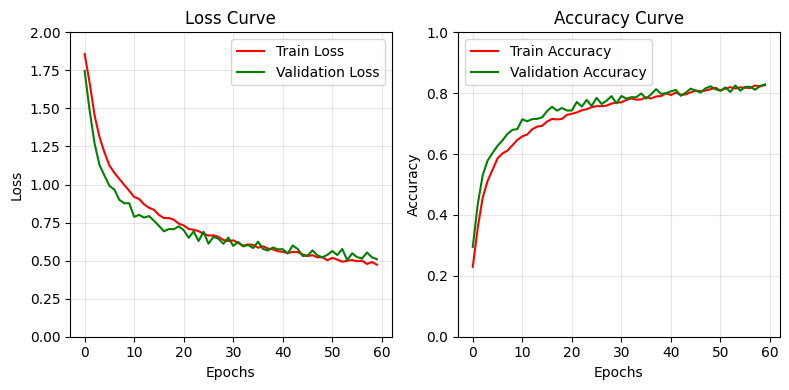

In [33]:
train_loss = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']
train_accuracy = CNN_History.history['accuracy']
val_accuracy = CNN_History.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss', color='red')
ax[0].plot(val_loss, label='Validation Loss', color='green')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy', color='red')
ax[1].plot(val_accuracy, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()

In [34]:
train_CNNresult = cnn_model.evaluate(train_images_CNNreshaped, Y_train_cat)
test_CNNresult = cnn_model.evaluate(test_images_CNNreshaped, Y_test_cat)

# Evaluate the CNN model
print("Train Loss: {:.2f}%".format(train_CNNresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_CNNresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_CNNresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_CNNresult[1] * 100))

575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9050 - loss: 0.2712
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8238 - loss: 0.5189
Train Loss: 27.32%
Train Accuracy: 90.34%

Test Loss: 50.93%
Test Accuracy: 82.91%


In [35]:
# Predict on the test set
y_predCNN_prob = cnn_model.predict(test_images_CNNreshaped)  # Predict probabilities
y_predCNN = np.argmax(y_predCNN_prob, axis=1)   # Convert to class labels
y_true = np.argmax(Y_test_cat, axis=1)   # Convert one-hot encoded labels to class indices

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_predCNN, target_names=classes))

192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification Report:
              precision    recall  f1-score   support

    surprise       0.79      0.93      0.86       870
        fear       0.91      0.94      0.92       840
     disgust       0.82      0.77      0.79       910
       happy       0.91      0.82      0.87       887
         sad       0.80      0.71      0.75       865
       angry       0.90      0.88      0.89       859
     neutral       0.70      0.75      0.72       894

    accuracy                           0.83      6125
   macro avg       0.83      0.83      0.83      6125
weighted avg       0.83      0.83      0.83      6125



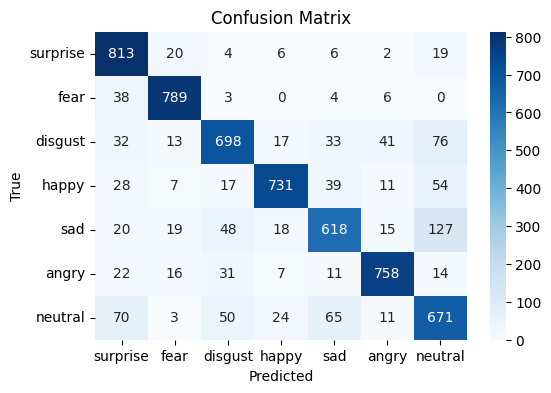

In [36]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_predCNN)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

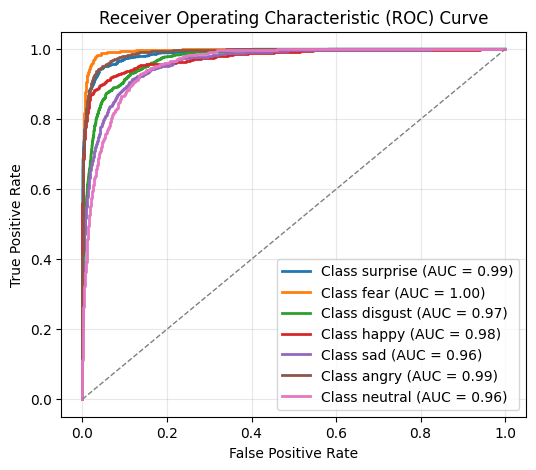

In [37]:
# Binarize the true labels for multi-class ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

# Initialisation des FPR, TPR, et AUC pour chaque classe
fpr = {}
tpr = {}
roc_auc = {}

# Calcul des courbes ROC et de l'AUC pour chaque classe
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_predCNN_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer toutes les courbes ROC
plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Ligne de référence pour une prédiction aléatoire
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Personnalisation du graphique
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

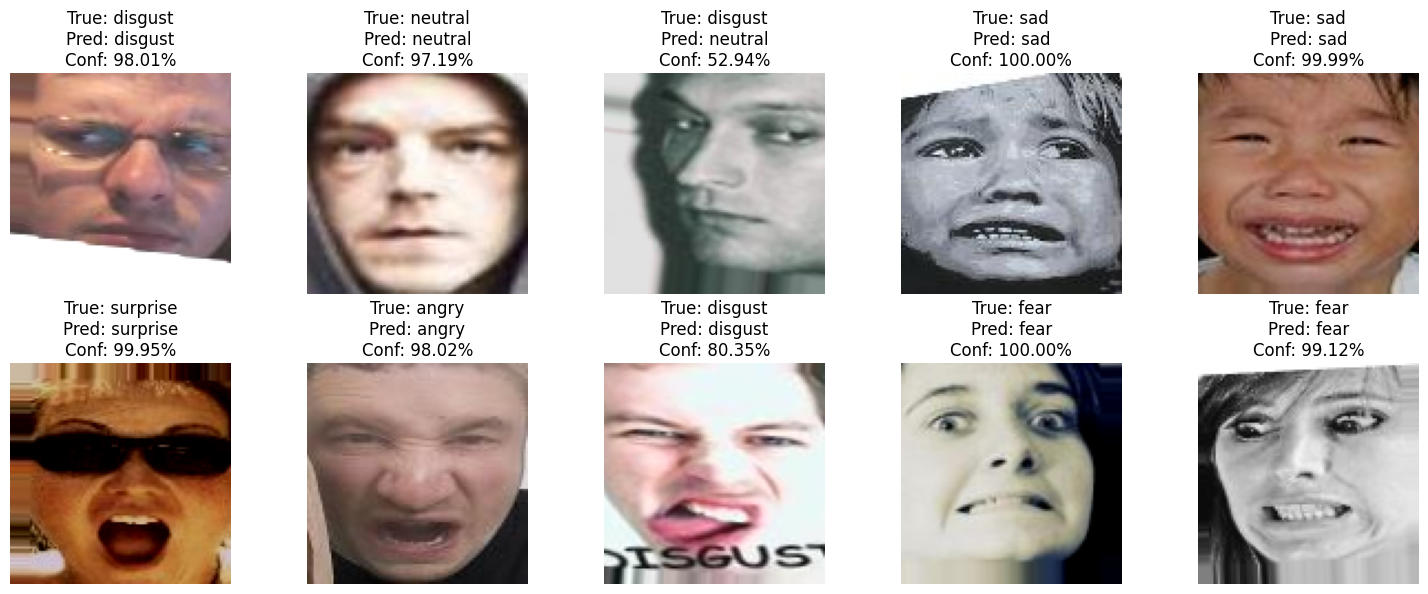

In [38]:
random_indices = np.random.choice(len(test_images_CNNreshaped), 10, replace=False)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    image = test_images_CNNreshaped[idx]
    true_class = classes[Y_test[idx] - 1]  
    pred_class = classes[y_predCNN[idx]]  
    confidence = np.max(y_predCNN_prob[idx]) * 100   
    
    # Plotting
    ax[i // 5, i % 5].imshow(image)
    ax[i // 5, i % 5].axis('off')  
    ax[i // 5, i % 5].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}%')

plt.tight_layout()
plt.show()

In [39]:
del CNN_History, train_loss, val_loss, train_accuracy, val_accuracy, train_CNNresult
# Clear memory
clear_session()
gc.collect()

0

3. DenseNet Model

In [ ]:
III. Model 

In [40]:
# Load the DenseNet model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(test_images_CNNreshaped[0].shape))

# Add custom layers on top of DenseNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output_tensor  = Dense(len(classes), activation='softmax')(x)

DenseNet_model = Model(inputs=base_model.input, outputs=output_tensor)

# Freeze base layers of DenseNet
for layer in base_model.layers:
    layer.trainable = False

DenseNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
DenseNet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 106, 106, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 25, 25, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 25, 25, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 25, 25, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,565,895 (28.86 MB)

 Trainable params: 528,391 (2.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [42]:
# Train the DenseNet model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)  
checkpoint = ModelCheckpoint(filepath='best_DenseNetModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

DenseNet_History = DenseNet_model.fit(
    train_generator, 
    epochs=60, 
    batch_size = 32,
    validation_data=(test_images_CNNreshaped, Y_test_cat), 
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3221 - loss: 1.9761
Epoch 1: val_accuracy improved from -inf to 0.47086, saving model to best_DenseNetModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 114s 285ms/step - accuracy: 0.3223 - loss: 1.9751 - val_accuracy: 0.4709 - val_loss: 1.4243 - learning_rate: 0.0010
Epoch 2/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4440 - loss: 1.4722
Epoch 2: val_accuracy improved from 0.47086 to 0.49306, saving model to best_DenseNetModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 47s 162ms/step - accuracy: 0.4440 - loss: 1.4722 - val_accuracy: 0.4931 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 3/60
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4682 - loss: 1.4213
Epoch 3: val_accuracy improved from 0.49306 to 0.50661, saving model to best_DenseNetModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.4682 - loss: 1.4212 - val_accuracy: 0.5066 - val_loss: 1.3261 - learning_rate: 0.0010
Epoch 4/60
288/

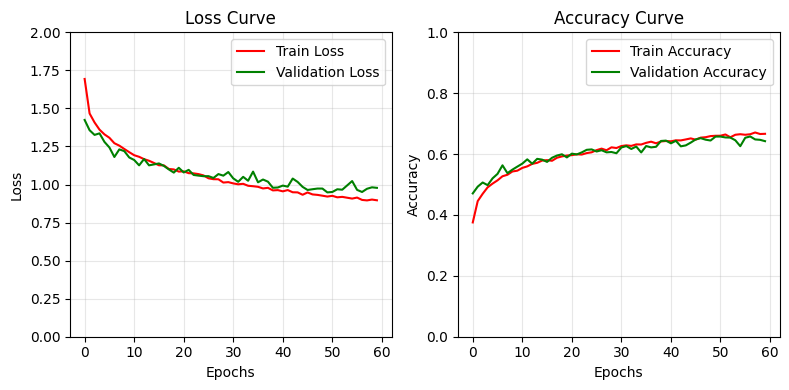

In [43]:
train_loss = DenseNet_History.history['loss']
val_loss = DenseNet_History.history['val_loss']
train_accuracy = DenseNet_History.history['accuracy']
val_accuracy = DenseNet_History.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss', color='red')
ax[0].plot(val_loss, label='Validation Loss', color='green')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy', color='red')
ax[1].plot(val_accuracy, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()

In [44]:
train_DenseNetresult = DenseNet_model.evaluate(train_images_CNNreshaped, Y_train_cat)
test_DenseNetresult = DenseNet_model.evaluate(test_images_CNNreshaped, Y_test_cat)

# Evaluate the DenseNet model
print("Train Loss: {:.2f}%".format(train_DenseNetresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_DenseNetresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_DenseNetresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_DenseNetresult[1] * 100))

575/575 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.7612 - loss: 0.6688
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6659 - loss: 0.9322
Train Loss: 67.55%
Train Accuracy: 75.61%

Test Loss: 95.10%
Test Accuracy: 65.80%


In [45]:
# Predict on the test set
y_predDenseNet_prob = DenseNet_model.predict(test_images_CNNreshaped)  # Predict probabilities
y_predDenseNet = np.argmax(y_predDenseNet_prob, axis=1)   # Convert to class labels
y_true = np.argmax(Y_test_cat, axis=1)   # Convert one-hot encoded labels to class indices

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_predDenseNet, target_names=classes))

192/192 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step
Classification Report:
              precision    recall  f1-score   support

    surprise       0.71      0.64      0.67       870
        fear       0.88      0.86      0.87       840
     disgust       0.72      0.51      0.60       910
       happy       0.59      0.72      0.65       887
         sad       0.55      0.57      0.56       865
       angry       0.84      0.66      0.73       859
     neutral       0.48      0.65      0.55       894

    accuracy                           0.66      6125
   macro avg       0.68      0.66      0.66      6125
weighted avg       0.68      0.66      0.66      6125



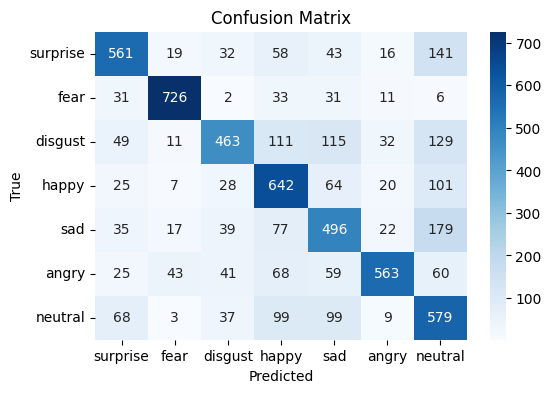

In [46]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_predDenseNet)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

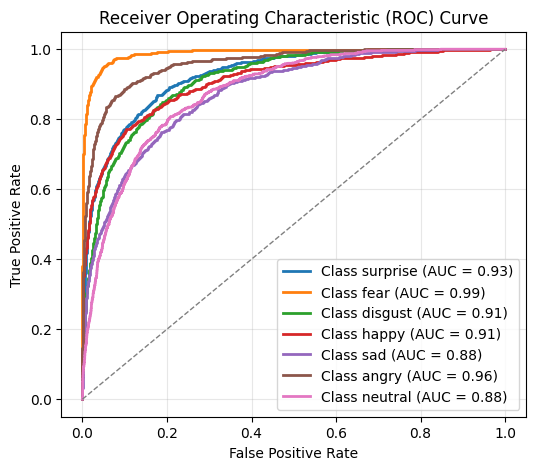

In [47]:
# Binarize the true labels for multi-class ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

# Initialisation des FPR, TPR, et AUC pour chaque classe
fpr = {}
tpr = {}
roc_auc = {}

# Calcul des courbes ROC et de l'AUC pour chaque classe
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_predDenseNet_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer toutes les courbes ROC
plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Ligne de référence pour une prédiction aléatoire
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Personnalisation du graphique
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

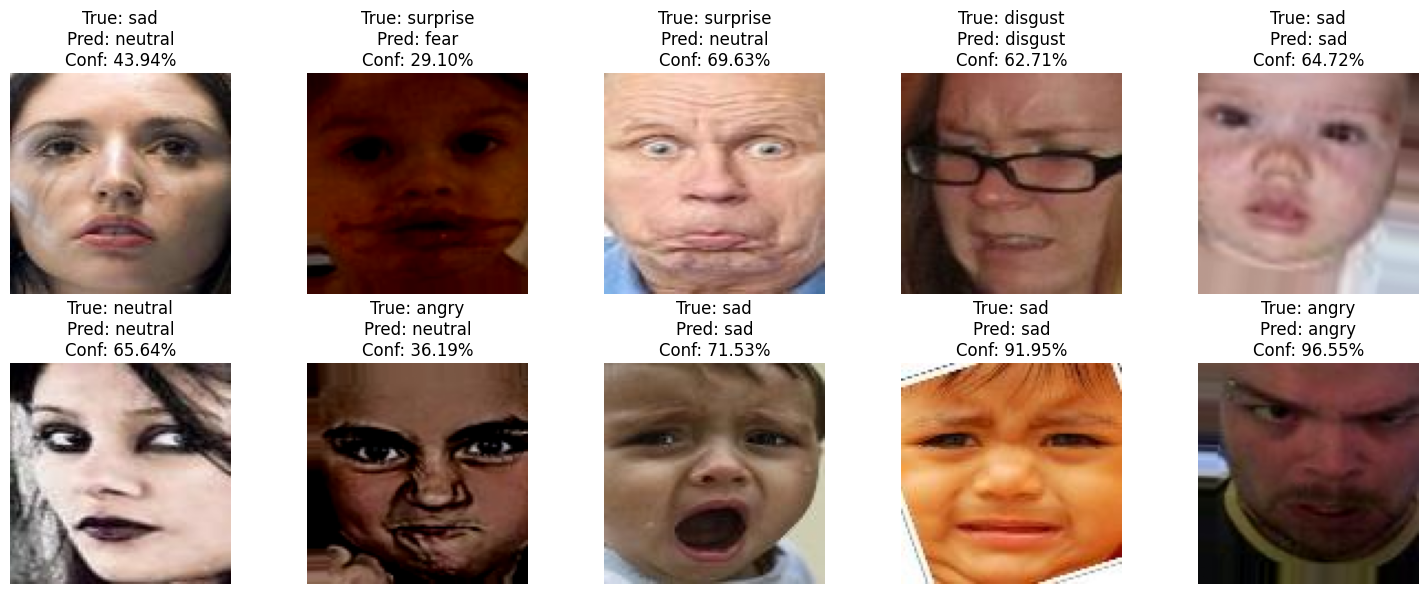

In [48]:
random_indices = np.random.choice(len(test_images_CNNreshaped), 10, replace=False)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    image = test_images_CNNreshaped[idx]
    true_class = classes[Y_test[idx] - 1]  
    pred_class = classes[y_predDenseNet[idx]]  
    confidence = np.max(y_predDenseNet_prob[idx]) * 100 
    # Plotting
    ax[i // 5, i % 5].imshow(image)
    ax[i // 5, i % 5].axis('off')  
    ax[i // 5, i % 5].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}%')

plt.tight_layout()
plt.show()

In [49]:
del DenseNet_History, train_loss, val_loss, train_accuracy, val_accuracy, train_DenseNetresult
# Clear memory
clear_session()
gc.collect()

0

**IV. Comparison**

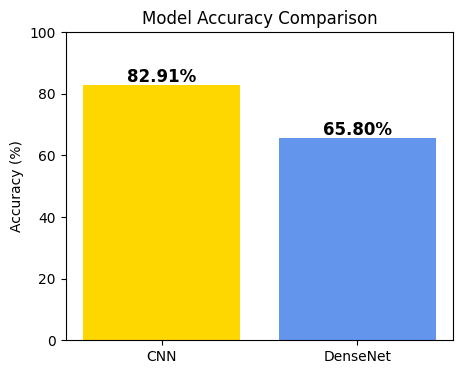

In [53]:
# Comparison of accuracies
cnn_accuracy = test_CNNresult[1] * 100
DenseNet_accuracy = test_DenseNetresult[1] * 100

# Models and their accuracies
models = ['CNN', 'DenseNet']
accuracies = [  cnn_accuracy, DenseNet_accuracy]

# Determine the index of the best model
best_accuracy = max(accuracies)
best_model_index = accuracies.index(best_accuracy)

# Create a chart with different colors for the best model
colors = ['cornflowerblue', 'cornflowerblue', 'cornflowerblue']
colors[best_model_index] = 'gold'

# create graph
plt.figure(figsize=(5, 4))
bars = plt.bar(models, accuracies, color=colors)

# Add the percentages above the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f'{accuracy:.2f}%', ha='center', fontweight='bold', fontsize=12)

plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 100])

# show graph
plt.show()


In [55]:
import joblib  # đảm bảo bạn đã import thư viện này

best_model = models[best_model_index]

if best_model == 'Random Forest':
    model_file = 'best_model_rf.pkl'
    joblib.dump(rf_model, model_file)

elif best_model in ['CNN', 'DenseNet']:
    model_file = 'best_model.h5'
    if best_model == 'CNN':
        cnn_model.save(model_file)
    elif best_model == 'DenseNet':
        DenseNet_model.save(model_file)

print(f"The best model is {best_model} and has been saved as {model_file}")


The best model is CNN and has been saved as best_model.h5


In [56]:
import joblib  # đảm bảo thư viện này đã được import

best_model = models[best_model_index]

if best_model == 'Random Forest':
    model_file = 'best_model_rf.pkl'
    joblib.dump(rf_model, model_file)

elif best_model in ['CNN', 'DenseNet']:
    if best_model == 'CNN':
        model = cnn_model
    elif best_model == 'DenseNet':
        model = DenseNet_model

    # Lưu kiến trúc (.json)
    json_file = f'best_model_{best_model.lower()}.json'
    with open(json_file, 'w') as f:
        f.write(model.to_json())

    # Lưu toàn bộ mô hình (.h5)
    model_file = f'best_model_{best_model.lower()}.h5'
    model.save(model_file)

    print(f"✅ {best_model} model saved as:")
    print(f"📄 JSON: {json_file}")
    print(f"💾 H5:   {model_file}")

else:
    print("❌ Unknown model type!")

# In tên mô hình tốt nhất
print(f"🏆 The best model is: {best_model}")


✅ CNN model saved as:
📄 JSON: best_model_cnn.json
💾 H5:   best_model_cnn.h5
🏆 The best model is: CNN
